# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|                  Name                     |      Campus Email              | Personal Email        |
|-------------------------------------------|--------------------------------|-----------------------|
|[Itai Benyamin](https://github.com/Itai-b) | itai.b@campus.technion.ac.il   |itai.benyamin@gmail.com|
|[Idan Baruch](https://github.com/idanbaru) | idan-b@campus.technion.ac.il   |idanb12200@gmail.com   |

## Imports

In [1]:
import os
import gc
import shutil
import xmltodict
import random
import numpy as np
import optuna
import pandas as pd
import time
import copy
import re
from enum import Enum
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("pytorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No device")

pytorch version: 2.5.1
torchvision version: 0.20.1
Is CUDA available: True
CUDA version: 11.8
PyTorch built with CUDA: True
Available devices: 1
Current device: NVIDIA GeForce RTX 3090


## Data Loading

In [4]:
# Download the data using Kaggle API and save it to the data folder
#kaggle_datapath = 'andrewmvd/pothole-detection'
#data_path = 'data/andrewmvd_pothole_detection'
kaggle_datapath = 'chitholian/annotated-potholes-dataset'
data_path = 'data/chitholian_annotated_potholes_dataset'
if not os.path.exists(data_path):
    #Load the data from kaggle
    data = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data, data_path)
    # if the data is from chitholian, we need to split it to two folders "images" and "annotations"
    if 'chitholian' in kaggle_datapath:
        # Create the folders
        os.makedirs(os.path.join(data_path, 'images'), exist_ok=True)
        os.makedirs(os.path.join(data_path, 'annotations'), exist_ok=True)
        # Move the files
        annotated_images_dir = os.path.join(data_path, 'annotated-images') 
        for file in os.listdir(annotated_images_dir):
            if file.endswith('.xml'):
                shutil.move(os.path.join(annotated_images_dir, file), os.path.join(data_path, 'annotations', file))
            else:
                shutil.move(os.path.join(annotated_images_dir, file), os.path.join(data_path, 'images', file))
        # remove the empty folder
        os.rmdir(annotated_images_dir)
else:
    print('Data already exists')

Data already exists


In [5]:
class PotholeSeverity(Enum):
    """
    Enum class for the severity of potholes.
    The severity levels ranges from 0 (no pothole) to 4 (major pothole):
        0 - No pothole (background, shouldn't be a detection target)
        temporary 1 - general pothole, no specific severity)
        1 - Minor pothole (road damage that is non-dangerous for padestrians)
        2 - Medium pothole (road damage that is dangerous for padestrians, but not for vehicles)
        3 - Major pothole (road damage that is dangerous for both vehicles and padestrians)
    """
    NO_POTHOLE = 0
    POTHOLE = 1 # TODO - this label is for temporary until we classify each saverity in the data.
    #MINOR_POTHOLE = 1
    #MEDIUM_POTHOLE = 2
    #MAJOR_POTHOLE = 3

def get_label_name(label):
    return PotholeSeverity(label).name

class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        
        # Preprocess data
        self.img_files, self.ann_files = self._preprocess_dataset()

    
    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')

    def _preprocess_dataset(self):
        # Get images from folder
        img_files = sorted(os.listdir(self.img_dir), key=self._extract_index)
        ann_files = sorted(os.listdir(self.ann_dir), key=self._extract_index)

        valid_img_files = []
        valid_ann_files = []

        # Parse images and annotated boxes to return only the valid images and boxes
        for img_file, ann_file in zip(img_files, ann_files):
            img_path = os.path.join(self.img_dir, img_file)
            ann_path = os.path.join(self.ann_dir, ann_file)
            
            # Load and validate
            img = cv2.imread(img_path)
            img_height, img_width = img.shape[:2]
            boxes, _ = self.parse_voc_annotation(ann_path)
            
            if self._check_boxes_validity(boxes, img_width, img_height):
                valid_img_files.append(img_file)
                valid_ann_files.append(ann_file)
                assert len(valid_img_files) == len(valid_ann_files)
        
        print(f'Number of valid images: {len(valid_img_files)}')
        return valid_img_files, valid_ann_files
    
    @staticmethod
    def _check_boxes_validity(boxes, img_width, img_height):
        for xmin, ymin, xmax, ymax in boxes:
            width = xmax - xmin
            height = ymax - ymin
            
            if width <= 0 or height <= 0:
                return False
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False
        return True

    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        labels = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(PotholeSeverity.POTHOLE.value)
        
        return boxes, labels
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes, labels = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
            
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx], dtype=torch.int64),
                "area": torch.tensor([(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes], dtype=torch.float32),
            }

        return img, target
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [6]:
# Paths to images and annotations
#data_path = 'data/andrewmvd_pothole_detection'
img_dir = os.path.join(data_path,"images")
ann_dir = os.path.join(data_path,"annotations")


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)

# Maintain the original indices while splitting
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.125, random_state=seed)

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")


Number of valid images: 664
Train set size: 464 - 69.88%
Validation set size: 67 - 10.09%
Test set size: 133 - 20.03%


In [7]:
# normalize the images according to the mean and std of the training set
# DataLoader for train set
train_loader = DataLoader(train_set, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Initialize accumulators for mean and std
n_pixels = 0
mean_sum = torch.zeros(3)
squared_sum = torch.zeros(3)

for imgs, _ in train_loader:
    for img in imgs:
        img = img.view(3, -1)  # Flatten each channel
        n_pixels += img.size(1)  # Add the number of pixels per channel
        mean_sum += img.sum(dim=1)
        squared_sum += (img ** 2).sum(dim=1)

# Compute mean and std
mean = mean_sum / n_pixels
std = torch.sqrt(squared_sum / n_pixels - mean ** 2)

print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

normalize = torchvision.transforms.Normalize(mean=mean.tolist(), std=std.tolist())

# Updated transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize,
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize,
])

# Recreate datasets with the updated transforms
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_test_transform
test_set.dataset.transform = val_test_transform

Training Set Mean: tensor([0.5288, 0.5161, 0.4917])
Training Set Std: tensor([0.1826, 0.1745, 0.1723])


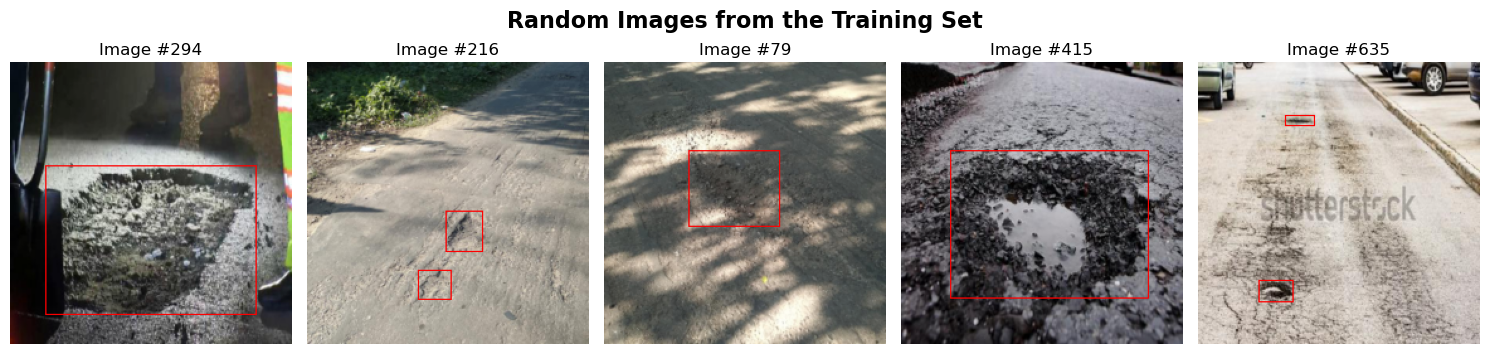

In [8]:
def convert_to_imshow_format(image, mean=mean, std=std):
    """
    Converts a normalized image tensor to the format expected by plt.imshow.
    Args:
        image (torch.Tensor): Normalized image tensor of shape [C, H, W].
        mean (torch.Tensor): Mean used for normalization (1D tensor of length 3 for RGB).
        std (torch.Tensor): Std used for normalization (1D tensor of length 3 for RGB).
    Returns:
        np.ndarray: Image array in HWC format, scaled to [0, 255] and uint8 type.
    """
    # Denormalize the image
    image = image * std[:, None, None] + mean[:, None, None]  # Reshape mean and std for broadcasting
    image = image.clamp(0, 1)  # Ensure values are in [0, 1] range
    
    # Convert to numpy and scale to [0, 255]
    image = (image.numpy() * 255).astype(np.uint8)
    
    # Convert from CHW to HWC
    return image.transpose(1, 2, 0)

# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, targets = next(iter(train_loader))

# Create a figure with subplots
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for idx, (img, target) in enumerate(zip(images, targets)):
    # Convert image to imshow format
    img_np = convert_to_imshow_format(img, mean, std)
    img_np = np.ascontiguousarray(img_np)  # Ensure compatibility with OpenCV
    
    # Draw bounding boxes and labels
    for box, label in zip(target["boxes"], target["labels"]):
        cv2.rectangle(img_np,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (255, 0, 0), 1)  # Blue box with thickness 2
        # label_name = get_label_name(label.item())
        # cv2.putText(img_np,
        #             label_name,
        #             (int(box[0]), int(box[1] - 5)),
        #             cv2.FONT_HERSHEY_SIMPLEX,
        #             0.5,
        #             (255, 0, 0), 1)  # Blue text
    
    # Display the image
    axes[idx].imshow(img_np)
    axes[idx].axis("off")
    axes[idx].set_title(f"Image #{target['image_id'].item()}")

plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.85)

plt.tight_layout()
plt.show()

## Two Stage Object Detector - Faster R-CNN

In [9]:
def preprocess_bbox(prediction, threshold=0.5):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [25]:
def evaluate_model(model, data_loader, threshold=0.5, num_iterations=1, batch_size=5):
    metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
    metric.to(device)
    
    all_predictions={}
    total_avg_time = 0
    
    model.eval()
    with torch.no_grad():
        for imgs,targets in data_loader:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            start_time = time.time()
            for _ in range(num_iterations):
                predictions=model(imgs)
            end_time = time.time()
            
            total_avg_time += (end_time - start_time) / (num_iterations * batch_size)
            
            results=[]
            for prediction, target in zip(predictions, targets):
                image_id = target["image_id"].item()
                results.append(preprocess_bbox(prediction, threshold))
                all_predictions[image_id]=prediction
            metric.update(results,targets)
    
    avg_time_per_batch = total_avg_time / len(data_loader)
    fps = 1 / avg_time_per_batch
    
    results=metric.compute()
    return all_predictions, results, fps

In [ ]:
from typing import List, Tuple
from torch import Tensor

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset) - pretrained
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


def custom_compute_loss(
    objectness: Tensor, pred_bbox_deltas: Tensor, labels: List[Tensor], regression_targets: List[Tensor]
) -> Tuple[Tensor, Tensor]:
    """
    Args:
        objectness (Tensor)
        pred_bbox_deltas (Tensor)
        labels (List[Tensor])
        regression_targets (List[Tensor])

    Returns:
        objectness_loss (Tensor)
        box_loss (Tensor)
    """
    sampled_pos_inds, sampled_neg_inds = model.rpn.fg_bg_sampler(labels)  # Access `fg_bg_sampler` from `model.rpn`
    sampled_pos_inds = torch.where(torch.cat(sampled_pos_inds, dim=0))[0]
    sampled_neg_inds = torch.where(torch.cat(sampled_neg_inds, dim=0))[0]

    sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)

    objectness = objectness.flatten()

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    box_loss = torchvision.ops.distance_box_iou_loss(
        pred_bbox_deltas[sampled_pos_inds],
        regression_targets[sampled_pos_inds],
        reduction="sum"
    ) / (sampled_inds.numel())

    objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

    return objectness_loss, box_loss

#overload the compute_loss function - add this after defining the model
#model.rpn.compute_loss = custom_compute_loss
#print(model.rpn.compute_loss)


In [ ]:
## clear memory
gc.collect()
torch.cuda.empty_cache()

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 5

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# Define optimizer and learning rate scheduler
# TODO - explain chosen hyperparameters
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
# TODO - explain the trade-off between batch size and number of epochs
# TODO -add validation check
num_epochs = 10

best_model_state_dict = model.state_dict()
best_val_map = 0.0
best_epoch = 0

## clear memory
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:

        # Prepare inputs for the model
        images = [img.to(device) for img in images]

        # Convert relevant target values to device
        targets_to_device = []
        for target in targets:
            targets_to_device.append({
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            })
    
        # Compute loss
        loss_dict = model(images, targets_to_device)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Compute validation loss
    _ , val_map, fps = evaluate_model(model, val_loader, batch_size=batch_size)
    mean_ap = val_map["map_50"].item()
    
    if (mean_ap > best_val_map):
        best_val_map = mean_ap
        best_model_state_dict = copy.deepcopy(model.state_dict())
        best_epoch = epoch
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation mAP@50: {mean_ap:.4f}, FPS: {fps:.2f}")

# Save the best trained model:
torch.save(best_model_state_dict, "faster_rcnn_pothole.pth")
print(f"Best Epoch: {best_epoch}, Best Val mAP@50: {best_val_map:.4f}")
print("Model training complete. Saved as 'faster_rcnn_pothole.pth'.")

Epoch 1/10, Loss: 36.9594, Validation mAP@50: 0.5814, FPS: 51.16
Epoch 2/10, Loss: 25.4579, Validation mAP@50: 0.6886, FPS: 50.79
Epoch 3/10, Loss: 21.1806, Validation mAP@50: 0.7253, FPS: 50.55
Epoch 4/10, Loss: 16.9796, Validation mAP@50: 0.7571, FPS: 50.41
Epoch 5/10, Loss: 15.5778, Validation mAP@50: 0.7433, FPS: 51.58
Epoch 6/10, Loss: 14.8897, Validation mAP@50: 0.7481, FPS: 51.42
Epoch 7/10, Loss: 13.9899, Validation mAP@50: 0.7534, FPS: 51.27
Epoch 8/10, Loss: 13.9587, Validation mAP@50: 0.7533, FPS: 51.00
Epoch 9/10, Loss: 13.7996, Validation mAP@50: 0.7547, FPS: 50.84
Epoch 10/10, Loss: 13.8236, Validation mAP@50: 0.7546, FPS: 50.82
Best Epoch: 3, Best Val mAP@50: 0.7571091055870056
Model training complete. Saved as 'faster_rcnn_pothole.pth'.


In [46]:
import json

def get_optimizer(trial, model_parameters):
    # Suggest optimizer type
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'AdamW', 'RMSprop'])
    
    # Common parameters
    
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.9, 0.99)
        lr = trial.suggest_float('lr', 5e-3, 5e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        return torch.optim.SGD(model_parameters, lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    elif optimizer_name == 'Adam':
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        beta1 = trial.suggest_float('beta1', 0.8, 0.999)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        return torch.optim.Adam(model_parameters, lr=lr, betas=(beta1, beta2))
    
    elif optimizer_name == 'AdamW':
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-2, log=True)
        beta1 = trial.suggest_float('beta1', 0.8, 0.999)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        return torch.optim.AdamW(model_parameters, lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
    
    else:  # RMSprop
        lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-1, 1, log=True)
        momentum = trial.suggest_float('momentum', 0.9, 0.99)
        return torch.optim.RMSprop(model_parameters, lr=lr, momentum=momentum, weight_decay=weight_decay)

def get_scheduler(trial, optimizer):
    # Suggest scheduler type
    scheduler_name = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau', 'OneCycleLR'])
    
    if scheduler_name == 'StepLR':
        step_size = trial.suggest_int('step_size', 2, 5)
        gamma = trial.suggest_float('gamma', 0.05, 0.5)
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    elif scheduler_name == 'CosineAnnealingLR':
        T_max = trial.suggest_int('T_max', 5, 15)
        eta_min = trial.suggest_float('eta_min', 1e-7, 1e-5, log=True)
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    
    elif scheduler_name == 'ReduceLROnPlateau':
        factor = trial.suggest_float('factor', 0.1, 0.5)
        patience = trial.suggest_int('patience', 2, 5)
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    
    else:  # OneCycleLR
        max_lr = trial.suggest_float('max_lr', 1e-4, 1e-2, log=True)
        return torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=trial.suggest_int('epochs', 15, 30), steps_per_epoch=len(train_loader))

def objective(trial): 
    ## clear memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # Define hyperparameter search space
    batch_size = trial.suggest_int('batch_size', 4, 8)
    num_epochs = trial.suggest_int('epochs', 10, 20)
    preweight_mode = trial.suggest_categorical('preweight_mode', ['freezing', 'fine_tuning', 'random'])

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Define the model
    if preweight_mode == 'random':
        model = models.detection.fasterrcnn_resnet50_fpn()  # No pre-trained weights
    else:
        model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

    # Replace the classifier with a single-class output
    num_classes = len(PotholeSeverity)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 
    
    if preweight_mode == 'freezing':
        # Freeze all layers except the head
        for param in model.parameters():
            param.requires_grad = False
        for param in model.roi_heads.box_predictor.parameters():
            param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Get optimizer and scheduler
    optimizer = get_optimizer(trial, model.parameters())
    scheduler = get_scheduler(trial, optimizer)
    
    # Training loop
    best_model_state_dict = model.state_dict
    best_map = 0.0
    prev_map = 0.0
    patience_counter = 0
    max_patience = 3  # Early stopping patience
    map_diff_threshold = 1e-2
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets_to_device = [{
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            } for target in targets]
            
            loss_dict = model(images, targets_to_device)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        # Evaluate on validation set
        _, val_map, fps = evaluate_model(model, val_loader, batch_size=batch_size)
        mean_ap = val_map["map_50"].item()
        
        # Step the scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(mean_ap)
        else:
            scheduler.step()
        
        # Report intermediate value
        trial.report(mean_ap, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        # Track best MAP and early stopping
        if mean_ap > best_map:
            best_map = mean_ap
            patience_counter = 0
        elif (np.abs(mean_ap - prev_map) < map_diff_threshold):
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
        
        torch.save(best_model_state_dict, f"./data/faster_rcnn/optuna/model_trial_{trial.number}_best.pth")

        print(f"Trial {trial.number} Epoch {epoch + 1}/{num_epochs}, "
              f"Loss: {epoch_loss:.4f}, Validation mAP@50: {mean_ap:.4f}, "
              f"FPS: {fps:.2f}")
        prev_map = mean_ap
        
    return best_map

def run_optimization(n_trials=50, optuna_path=None):
    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5),
        study_name="faster_rcnn_optimization",
        sampler=optuna.samplers.TPESampler(seed=seed)
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    # Print optimization results
    trial = study.best_trial
    print(f"\nBest trial: #{trial.number}")
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Plot optimization history
    try:
        import plotly
        fig = optuna.visualization.plot_optimization_history(study)
        fig.write_html(os.path.join(optuna_path,"optimization_history.html"))
        
        fig_importance = optuna.visualization.plot_param_importances(study)
        fig_importance.write_html(os.path.join(optuna_path,"parameter_importance.html"))
    except (ImportError, RuntimeError) as e:
        print("Plotting failed:", str(e))
    
    # Save study results
    study.trials_dataframe().to_csv(os.path.join(optuna_path,"optimization_results.csv"))
    
    return study

# Run the optimization
optuna_path = f'data/faster_rcnn/optuna'
study = run_optimization(n_trials=50, optuna_path=optuna_path)

[I 2025-01-20 18:03:32,047] A new study created in memory with name: faster_rcnn_optimization


Trial 0 Epoch 1/17, Loss: 56.3693, Validation mAP@50: 0.0000FPS: 50.82


[W 2025-01-20 18:04:42,612] Trial 0 failed with parameters: {'batch_size': 7, 'epochs': 17, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.0009472961959721175, 'beta1': 0.9658118084445251, 'beta2': 0.9318563294010559, 'scheduler': 'CosineAnnealingLR', 'T_max': 8, 'eta_min': 8.307341815284441e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/user_138/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_7691/1217038125.py", line 134, in objective
    _, val_map, fps = evaluate_model(model, val_loader, batch_size=batch_size)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_7691/130105651.py", line 16, in evaluate_model
    predictions=model(imgs)
                ^^^^^^^^^^^
  File "/home/user_138/anaconda3/envs/ultralytics-

KeyboardInterrupt: 

In [38]:
def visualize_predictions(images, targets, all_predictions, mean, std, threshold=0.5, show_severity=False):
    """
    Display images with ground truth and predicted bounding boxes.
    """
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, target) in enumerate(zip(images, targets)):
        # Convert image to imshow format
        img_np = convert_to_imshow_format(img, mean, std)
        img_np = np.ascontiguousarray(img_np)  # Ensure compatibility with OpenCV
        
        # Draw ground truth boxes (red)
        for box in target["boxes"]:
            cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 1)
            cv2.putText(img_np, "GT", (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Access predictions for the specific image_id
        predictions = all_predictions.get(target['image_id'].item(), {})
        if predictions:
            for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):
                if score < threshold:
                    continue
                xmin, ymin, xmax, ymax = map(int, box)
                cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
                if show_severity:
                    cv2.putText(img_np, 
                                f"P: {get_label_name(label)}: {score:.2f}", 
                                (xmin, ymin - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, 
                                (0, 255, 0), 2)  # Green text, thickness=2
                else:
                    cv2.putText(img_np, 
                                f"P: {score:.2f}", 
                                (xmin, ymax + 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, 
                                (0, 255, 0), 1)
        
        # Display the image with annotations
        axs[i].imshow(img_np)
        axs[i].axis("off")
        axs[i].set_title(f"Image #{target['image_id'].item()}")

    # Add a main title
    plt.suptitle("Random Test Batch Predictions", fontsize=16, fontweight="bold", y=0.9)

    plt.tight_layout()
    plt.show()


Mean Average Precision @ 0.5 : 0.6586 FPS: 49.15


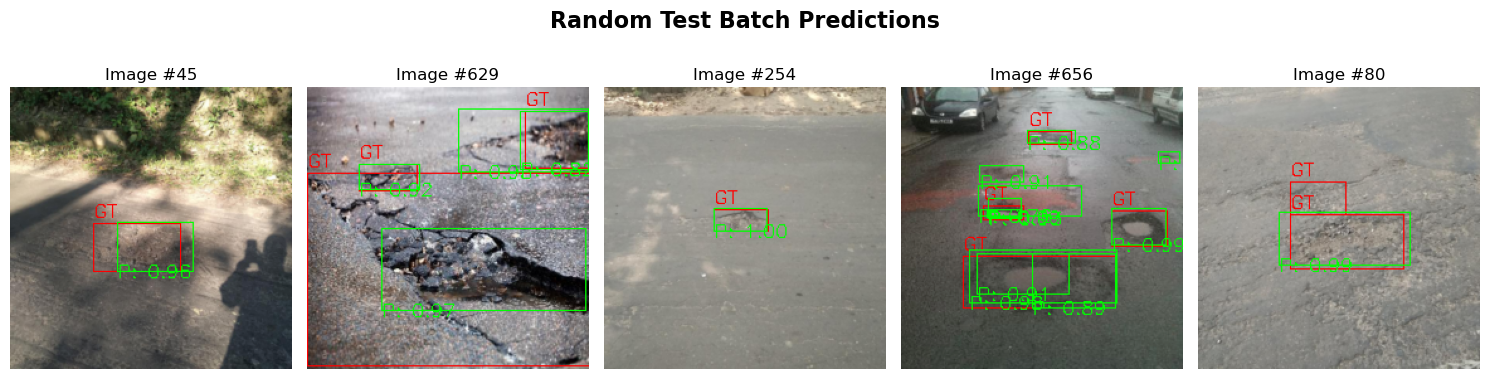

In [44]:
# Load the trained model
optuna_path = f'data/faster_rcnn/optuna'

# Load the best model
#checkpoint_path = os.path.join(optuna_path, f"model_trial_{study.best_trial.number}_best.pth")
checkpoint_path = f"faster_rcnn_pothole.pth"

model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(PotholeSeverity)) 
state_dict = torch.load(checkpoint_path, weights_only=True)
model.load_state_dict(state_dict)

model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

predictions, results, fps = evaluate_model(model, test_loader, num_iterations=1, threshold=0.5)

mean_ap_50=results["map_50"].item()
print(f"Mean Average Precision @ 0.5 : {mean_ap_50:.4f}",
      f"FPS: {fps:.2f}")

# Select a random batch
random_batch = random.choice(list(test_loader))  # Select a random batch
images, targets = random_batch

visualize_predictions(images, targets, predictions, mean=mean, std=std, threshold=0.5, show_severity=False)